In [ ]:
import cv2 as cv
from typing import Any
from scipy.spatial import Delaunay, Voronoi
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
img = cv.imread('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/IMG_1814.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
h,w = img.shape[:2]
new_dim = (w//4, h//4)
print(new_dim)
resized = cv.resize(img, new_dim, interpolation=cv.INTER_CUBIC)
# cv.imwrite("/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/book_small.jpg", resized)

(756, 1008)


In [67]:
resized.shape

(1008, 756, 3)

In [ ]:
class AbstractTransformation:
    def __init__(self, img: cv.typing.MatLike):
        self.img = img
        self.width, self.height = img.shape[:2][::-1]
        self.min_distance = min(self.width, self.height) // 30
        
    
    def generate_points(self, method: str = 'triangular', density: int = 100) -> np.ndarray:
        if method == 'triangular':
            return self._constrained_random_points(density)
        else:
            raise ValueError(f"Unknown method: {method}")

    def _pure_random_points(self, num_points: int) -> np.ndarray:
        rows = np.random.randint(0, self.height, size=num_points)
        cols = np.random.randint(0, self.width, size=num_points)
        return np.column_stack((cols, rows))
    
    def _generate_random_point(self) -> np.ndarray:
        return np.array(
            [random.randint(0, self.width), random.randint(0, self.height)]
        )

    def _is_valid_point(self, existing_points: np.ndarray, candidate: np.ndarray) -> bool:
        if len(existing_points) == 0:
            return True
        distances = np.sqrt(np.sum((existing_points - candidate)**2, axis=1))
        return np.all(distances >= self.min_distance)

    
    def _constrained_random_points(self, num_points: int, retries: int = 10) -> np.ndarray:
        result = []
        result.append(self._generate_random_point())
        for _ in range(1, num_points):
            candidate = None
            attempts = retries
            while attempts > 0:
                candidate = self._generate_random_point()
                if self._is_valid_point(np.array(result), candidate):
                    result.append(candidate)
                    break
                else:
                    attempts -= 1
            if attempts == 0:
                break
        return np.array(result)

    def _create_triangulation(self, points: np.ndarray) -> np.ndarray:
        triangles = Delaunay(points)
        return triangles.simplices
    
    def triangular_abstraction(self):
        abstract = np.zeros_like(self.img)
        points = self.generate_points(method='triangular', density=200)
        triangles = self._create_triangulation(points)
        for triangle in triangles:
            # find centroid
            poly = np.array([points[triangle[0]], points[triangle[1]], points[triangle[2]]])
            centroid = np.mean(poly, axis=0).astype(int)
            # sample color
            color = self.img[centroid[1], centroid[0]]
            # fill polygons
            cv.fillPoly(abstract, [poly], color.tolist())
        return abstract

    

    def visualize_triangulation(self, points: np.ndarray, triangles: np.ndarray) -> None:
        result = self.img.copy()
        for triangle in triangles:
            tri_points = points[triangle].astype(np.int32)
            cv.polylines(result, [tri_points], True, (0, 255, 0), 1)
        
        for point in points:
            cv.circle(result, tuple(point.astype(int)), 3, (255, 0, 0), -1)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(result)
        plt.title(f'{len(points)} - points, {len(triangles)} - triangles')
        plt.axis('off')
        plt.show()

In [69]:
transformer = AbstractTransformation(resized)


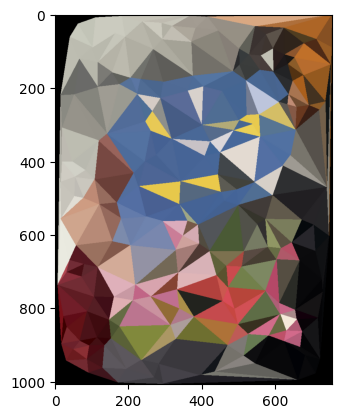

In [71]:
abstract = transformer.triangular_abstraction()

plt.imshow(abstract)
plt.show()

In [ ]:
voronoi = Voronoi(points)

IndexError: invalid index to scalar variable.

In [37]:
# res = transformer.triangular_abstraction_2()
# plt.imshow(res)
# plt.show()

In [ ]:

abstract = np.zeros_like(resized)
points = transformer.generate_points(method='triangular', density=200)
centroid = np.mean(points, axis=0).astype(int)
color = resized[centroid[0], centroid[1]]
color.shape, centroid.shape


((3,), (2,))

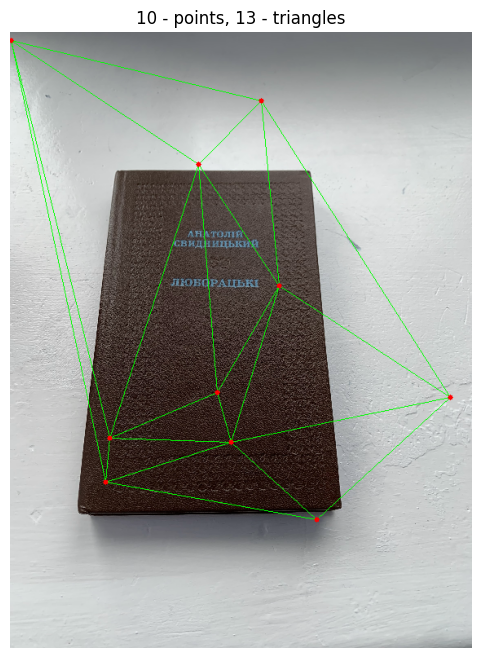

In [98]:
points = transformer._constrained_random_points(10)
triangles = transformer._create_triangulation(points)
transformer.visualize_triangulation(points, triangles)

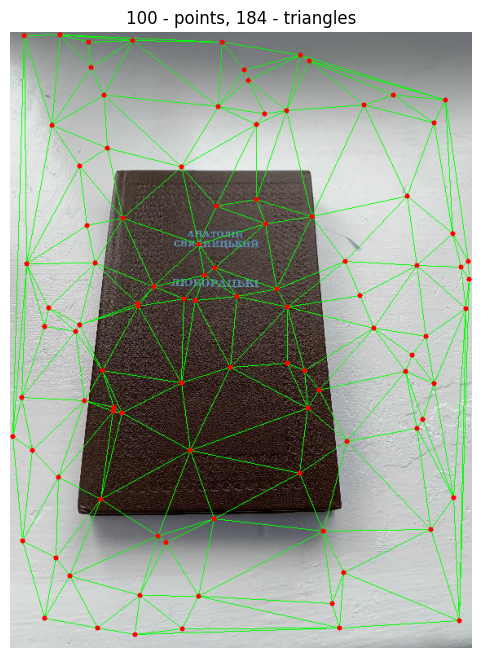

In [81]:
points = transformer._pure_random_points(100)
triangles = transformer._create_triangulation(points)
transformer.visualize_triangulation(points, triangles)



test__pure_random_points...
test_create_triangulation...
test_constrained_points...
pure random: 10
constraint random: 10


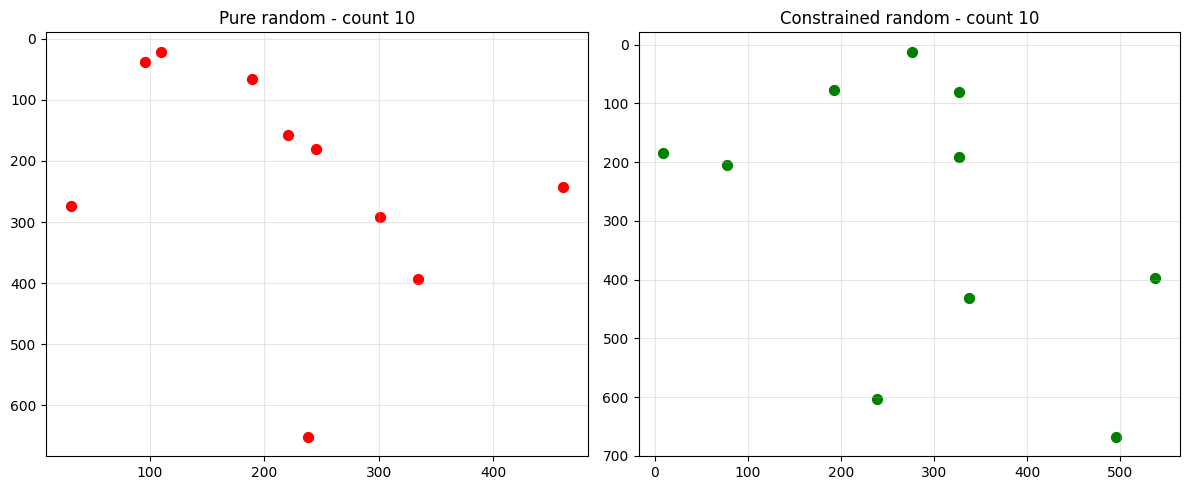

all tests passed


In [102]:
def test__pure_random_points():
    transformer = AbstractTransformation(resized)
    assert all([x <=transformer.width and y <=transformer.height] for (x, y) in transformer._pure_random_points(10))

def test_create_triangulation():
    samples = 10
    transformer = AbstractTransformation(resized)
    points = transformer._pure_random_points(samples)
    triangles = transformer._create_triangulation(points)
    assert points.shape == (samples, 2)
    assert len(triangles) > len(points)
    assert len(triangles[0]) == 3

def test_constrained_points():
    samples = 10
    transformer = AbstractTransformation(resized)
    random_constraint_points = transformer._constrained_random_points(samples)
    random_points = transformer._pure_random_points(samples)

    print(f'pure random: {len(random_points)}')
    print(f'constraint random: {len(random_points)}')
    triangles = transformer._create_triangulation(points)
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # plot random
    ax1.scatter(random_points[:, 0], random_points[:, 1], c='red', s=50)
    # ax1.set_xlim(0, 300)
    # ax1.set_ylim(0, 200)
    ax1.invert_yaxis()
    ax1.set_title(f'Pure random - count {len(random_points)}')
    ax1.grid(True, alpha=0.3)

    # plot constrained
    ax2.scatter(random_constraint_points[:, 0], random_constraint_points[:, 1], c='green', s=50)
    # ax2.set_xlim(0, 300)
    # ax2.set_ylim(0, 200)
    ax2.invert_yaxis()
    ax2.set_title(f'Constrained random - count {len(random_constraint_points)}')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def run_tests():
    for k,v  in globals().items():
        if k.startswith('test_'):
            print(f'{k}...'); v()

    print('all tests passed')


run_tests()

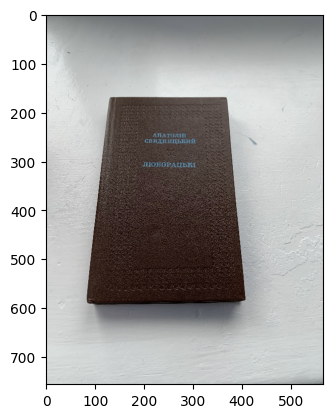

In [15]:
plt.imshow(resized)
plt.show()

In [26]:
resized.shape[:2][::-1]

(567, 756)

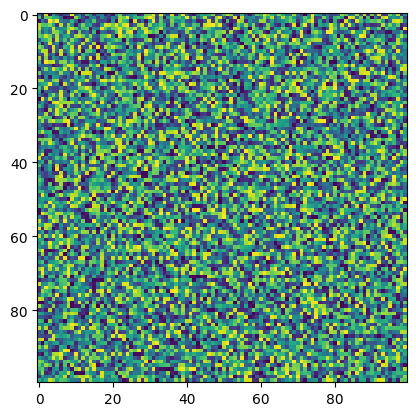

In [91]:
im = np.random.randint(0, 255, size=(100, 100))
plt.imshow(im)
plt.show()
